In [ ]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from google.colab import files
import pandas as pd
plt.rcParams["figure.figsize"] = (10,8)

In [ ]:
#Creating a simulation class: 

#Note: Constants for burst size, latency and adsorbption come from this paper:
#The paper used E.coli and T4 with LB broth.
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5911998/


class Simulation():

  def __init__(self,U,Y0=1E8,burst_constant = 89.5):
    self.burst_constant = burst_constant
    self.ecoli_per_od1 = 8E8  # concentration of e-coli / mL in a solution with OD = 1
    self.U = U  # growth rate in hours^-1
    # self.A = 6.24e-8   # Absorbtion rate likelyhood of a single virus infecting a single cell in 1 mL of solution in 1 hour.
    self.A = self.adsorbtion_cnt_calculator(U)
    self.B = self.burst_size_calculator(U)  # Burst size number of phage released when a single cell lyses, was 60
    self.L = self.latency_time_calculator(U) #Latency time in hours
    print("Absorbtion Constant = ", self.A, "Burst Size = ", self.B, "Latency Time= ", self.L)
    self.K = .9*self.ecoli_per_od1  #Carrying capacity
    self.X0 = .2*self.ecoli_per_od1  # initial concentration  of bacteria
    # self.X0 = 6E8 * .25 / 26
    self.Y0 = Y0 # Free phage initial concentration
    print("Initial Concentrations", self.X0, self.Y0)
    self.DELTA_T = 1/300 # hours
    self.x = [self.X0] # Bacteria concentration
    self.y = [self.Y0] # Free Phage concentration
    self.z = [0]       # Bound phage concentration. 
    self.time = [0]
    self.last_printed_time = 0
    self.turb_od_limit = 0.4
    self.turb_od_floor = 0.2

  def adsorbtion_cnt_calculator(self, growth_rate):
    #Note: these constants are from LB
    Kads = 0.060 #hr-1
    Smax = 5E-9 #ml*min-1
    Si = 4.75E-9 #ml*min-1 ## not really sure what this parameter stands for.. 

    # Is it possible to wrap the latency time into the adsorbtion constant?
    #S = 60*( Smax - Si*(growth_rate)/(Kads + growth_rate))
    S = 60*( Smax - Si*(growth_rate)/(Kads + growth_rate)) / self.latency_time_calculator(growth_rate)
    return S

  def burst_size_calculator(self,growth_rate):
    # Note: these constants are from LB
    burst_sz = self.burst_constant*growth_rate
    #burst_sz = 50*growth_rate

    print("Burst size", burst_sz)
    return burst_sz

  def latency_time_calculator(self,growth_rate):
    #Note: These constants are from LB
    #Klat= .145 #hr-1
    Klat = .3
    #Lmin = 40.5
    Lmin = 25.5 # min
    L = (Klat + growth_rate)/ (1/Lmin * growth_rate)
    return L/60

  
  def run_cycle(self):
    current_time = self.time[len(self.time)-1]+self.DELTA_T
    self.time.append(current_time)
    y1 = self.y[len(self.y)-1]
    x1 = self.x[len(self.x)-1]
    z1 = self.z[len(self.z)-1]

    #Adding some safety mechanisms if the bacteria concentration is zero:
    if x1 <=0:
      #If the bacteria concentration is less than zero, keep it at zero, and
      #make sure there is no phage reproduction
      x2 = 0
      y2 = y1
      z2 = 0
    else:
      if x1/self.ecoli_per_od1 > self.turb_od_limit:
        # bring the concentrations to the od floor
        x1 = x1 * self.turb_od_floor / self.turb_od_limit
        y1 = y1 * self.turb_od_floor / self.turb_od_limit
        z1 = z1 * self.turb_od_floor / self.turb_od_limit
      
      # Now, use ODE's to adjust the concentrations: 
      x2 = x1 + self.DELTA_T*(self.U * x1 - self.L*z1)   # bacteria without carrying capacity
      y2 = y1 + self.DELTA_T * (self.L*z1*self.B-self.A *self.DELTA_T * y1 * x1)  # free phage = old + newly burst - newly adsorbed.
      z2 = z1 + self.DELTA_T*(self.A *self.DELTA_T * y1 * x1 - self.L*z1)  # Infected bacteria = old infected + new infections - lysed bacteria

      #Ignoring the effect of lag: 
      # x2 = x1 + self.DELTA_T*(self.U * x1 - self.A * self.DELTA_T * x1 * y1)  # bacteria without carrying capacity
      # # x2 = x1 + self.DELTA_T*(self.U * x1*(1-x1/self.K) - self.A * self.DELTA_T * x1 * y1)  # bacteria with carrying capacity
      # y2 = y1 + self.DELTA_T * (self.A *self.DELTA_T * y1 * x1 *self.B )  # phage
      # z2 = 0

    
      #ignoring the effect of phage: 
      # x2 = x1 + self.DELTA_T*(self.U * x1*(1-x1/self.K))

      if x2 < 0 :
        x2 = 0
    self.y.append(y2)
    self.x.append(x2)
    self.z.append(z2)

    # Print the outcoming data every 2 minutes
    # if current_time - self.last_printed_time > 2/60:
    #   print("Time = ", round(current_time,2), "OD = ", round(x2/self.ecoli_per_od1,4), 
    #         "Free Phage= ", round(y2,2), "Infected Bact" , round(z2,2))
    #   self.last_printed_time = current_time
    
  
  def run_simulation(self,trial_name, length_in_hrs = 40):
    # Length should be in hours
    while self.time[len(self.time)-1] < length_in_hrs:
      self.run_cycle()
    trial_data = {'Bacteria':np.array(self.x) / self.ecoli_per_od1, 'Phage':np.array(self.y), 'Time':np.array(self.time)}
    return [trial_name,trial_data]

  def plot_results(self,trial_names):
    plt.figure()
    plt.title("Phage Infection Modelling")
    # Convert E.Coli concentrations in to optical density values
    x_in_od = np.array(self.x) / self.ecoli_per_od1
    plt.figure()
    plt.title("Phage Infection")
    plt.plot(np.array(self.time), x_in_od, label = 'Bacteria')
    # plt.plot(self.time, self.y, label = 'Phage')
    plt.legend()
    plt.grid(True)
    plt.show()

Burst size 35.6
Absorbtion Constant =  7.014979905005482e-08 Burst Size =  35.6 Latency Time=  0.74375
Initial Concentrations 160000000.0 100000000.0
Burst size 28.0
Absorbtion Constant =  7.014979905005482e-08 Burst Size =  28.0 Latency Time=  0.74375
Initial Concentrations 160000000.0 100000000.0
Burst size 16.0
Absorbtion Constant =  7.014979905005482e-08 Burst Size =  16.0 Latency Time=  0.74375
Initial Concentrations 160000000.0 100000000.0


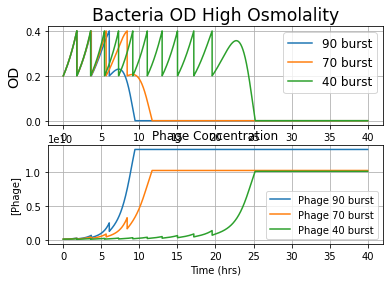

In [ ]:
#Running and plotting multiple simulations: 
all_expts = []  # experimental data will be saved here in the format of [[trial_name,{bacteria OD, phage conc,time}],...]
#Running first experimental condition
name1 = '90 burst'
sim1 = Simulation(U= .4,burst_constant= 89)
all_expts.append(sim1.run_simulation(trial_name = name1))
#Running second experimental condition
name2 = '70 burst'
sim2 = Simulation(U=.4, burst_constant= 70)
all_expts.append(sim2.run_simulation(trial_name = name2))

#Running third experimental condition
name3 = '40 burst'
sim3 = Simulation(U=.4, burst_constant=40)
all_expts.append(sim3.run_simulation(trial_name = name3))
names = [name1,name2, name3]
#Plotting the results: 

fig,(ax1,ax2) = plt.subplots(2,1)
plt.title("Phage Infection Modelling")
ax1.set_title('Bacteria OD High Osmolality', fontsize = 'xx-large')
ax1.set_ylabel('OD', fontsize = 'x-large')
ax1.grid(True)
ax1.set_xlabel('Time (hrs)', fontsize = 'x-large')
ax2.set_title('Phage Concentration')
ax2.set_ylabel('[Phage]')
ax2.set_xlabel('Time (hrs)')
ax2.grid(True)
for i,expt in enumerate(all_expts):
  data_dict = expt[1]
  ax1.plot(data_dict.get('Time'), data_dict.get('Bacteria'), label = names[i])
  ax2.plot(data_dict.get('Time'), data_dict.get('Phage'), label = 'Phage ' + expt[0])

# #Plotting the actual expt:
# ax1.plot([t-16 for t in time[2880:7400]], od_920[2880:7400], color = 'violet', label = 'Experimental Data' )
# ax1.vlines(0,0,.5,colors='red', label = 'Phage Added', linestyles= 'dashed')

ax1.legend(fontsize = 'large')
ax2.legend()
# plt.rcParams['figure.figsize'] = [20, 16]
plt.show()






In [ ]:
uploaded = files.upload()

NameError: ignored

In [ ]:
import io
#enter the specific name of the dataframe: 
# df = pd.read_excel(io.BytesIO(uploaded['Mar29_Phage_Osmo_Data.xlsx']))
xls = pd.ExcelFile(io.BytesIO(uploaded['Mar29_Phage_Osmo_Data.xlsx']))
df_od_zeroed = pd.read_excel(xls, 'OD_Zeroed')
df_time = pd.read_excel(xls, 'Time')
print(df_od_zeroed.head())
print(df_time.head())

# getting the 920 OD data as a list: 
od_920 = list(df_od_zeroed['OD  920 mOsm vial 11'])
time = list(df_time['Time (hours)'])




NameError: ignored